Inspiration from: https://medium.com/@koki_noda/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

In [3]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [4]:
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader

# Download and process data at './dataset/ogbg_molhiv/'
dataset = PygGraphPropPredDataset(name = 'ogbg-ppa', root = data_dir)
# Number of nodes: 2708

In [7]:
dataset.get_summary()

100%|██████████| 158100/158100 [00:05<00:00, 27259.81it/s]


PygGraphPropPredDataset (#graphs=158100):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    243.4 |   4532.2 |
| std        |     85.4 |   2615.3 |
| min        |     50   |    108   |
| quantile25 |    182   |   2960   |
| median     |    300   |   4274   |
| quantile75 |    300   |   5716   |
| max        |    300   |  36138   |
+------------+----------+----------+

In [18]:
print(dataset.num_features)
print(dataset.num_classes)
print(dataset.num_tasks)
dataset.task_type

0
37
1


'multiclass classification'

In [19]:
dataset.meta_info

num tasks                                                                1
eval metric                                                            acc
download_name                                              ogbg_ppi_medium
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/graphproppre...
add_inverse_edge                                                      True
data type                                                                 
has_node_attr                                                        False
has_edge_attr                                                         True
task type                                        multiclass classification
num classes                                                             37
split                                                              species
additional node files                                                 None
additional edge files    

In [30]:
dataset.task_type

'multiclass classification'

In [27]:
#dont split the dataset

# Load the data

data = dataset[0]

# Get the number of nodes and edges
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")

Number of nodes: 300


In [28]:
print(f'Number of edges: {data.num_edges}')
# Number of edges: 10556

Number of edges: 4408


In [29]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [30]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 4408)


array([[ 30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30],
       [ 17,  28,  16, 166,  87,  21, 182,  80, 197,  14,  92,  23, 125]])

In [31]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 14.69


,count,mean,std,min,25%,50%,75%,max
0,300.0,14.69,15.77,1.0,5.0,10.0,19.25,113.0


300
4408


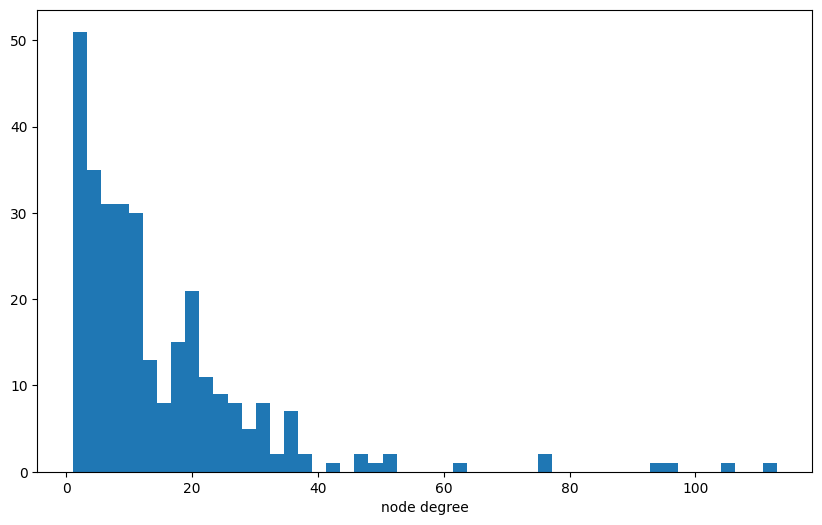

In [32]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.15719063545150502


/opt/anaconda3/envs/chatbot/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


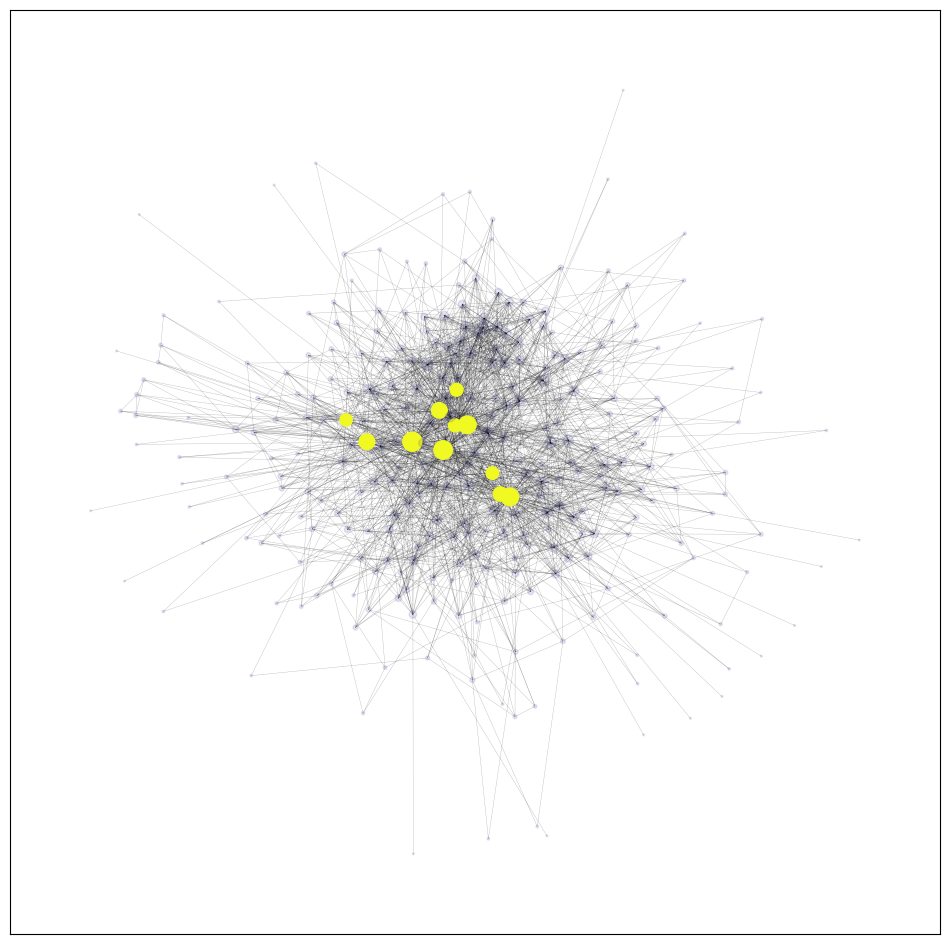

In [33]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

Features::::'

In [34]:
print(f'Number of features: {data.num_node_features}')
# Number of edge features: 0

Number of features: 0


In [35]:
print(f'Number of edge features: {data.num_edge_features}')
# Number of edge features: 0

Number of edge features: 7


Classes:

In [36]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

Number of classes: 37


In [37]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([[0]])

In [38]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

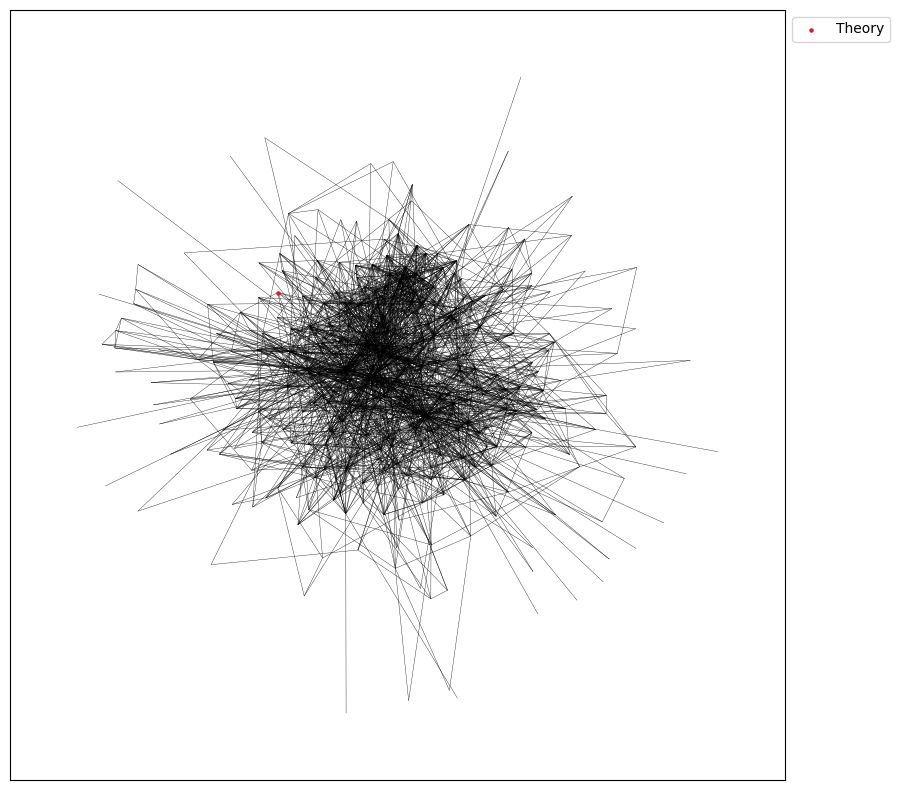

In [39]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

Homophily

In [40]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [41]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()
# 0.8099658961727927

NameError: name 'label_connection_counts' is not defined

In [42]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

NameError: name 'label_connection_counts' is not defined

Train,Test,Split

In [43]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

In [44]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
plt.scatter(range(2708), split_type_array)
plt.xlabel("index")
plt.show()

AttributeError: 'GlobalStorage' object has no attribute 'train_mask'

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


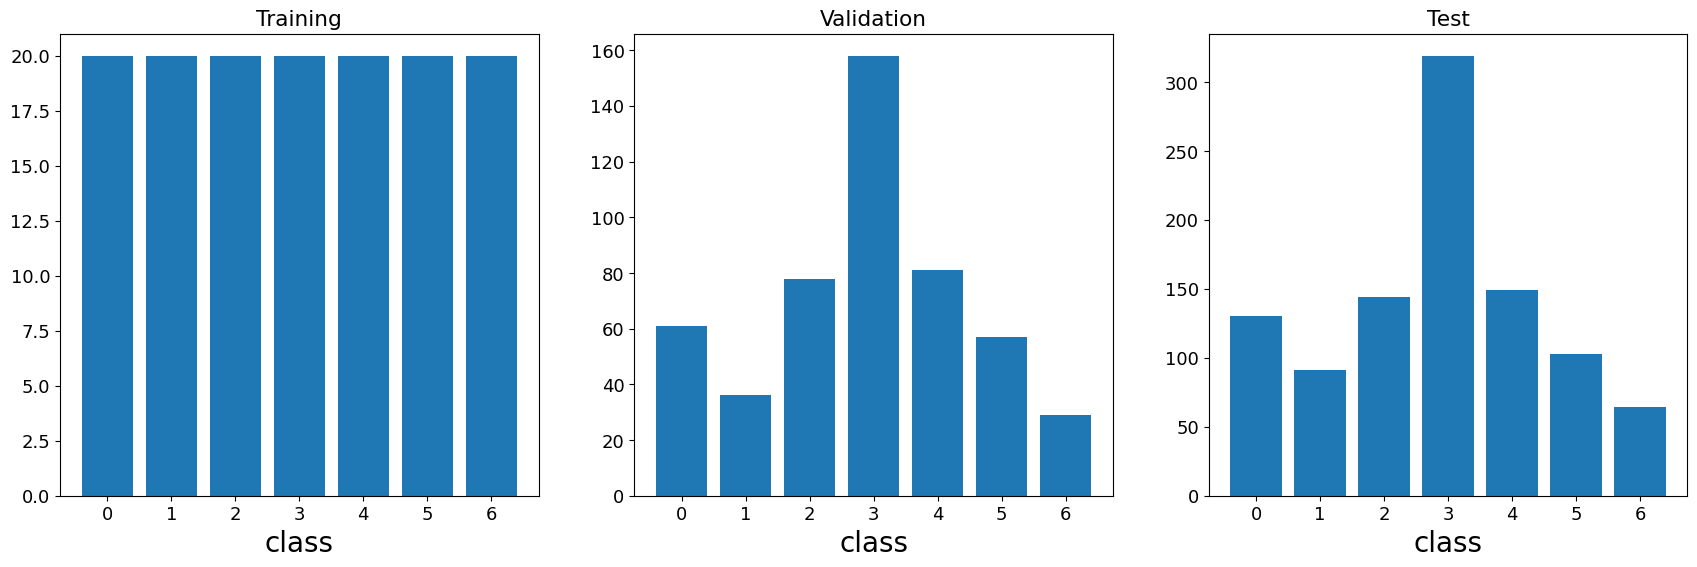

In [23]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
    # plt.figure(figsize=(10, 6))
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()